# Demoing fetching PV locations from DuckLake into a LanceDB dataset



### References:
- [DuckLake Documentation](https://ducklake.select/docs/stable/)
- [DuckLake with Ibis Python DataFrames](https://emilsadek.com/blog/ducklake-ibis/)
- [A new data lakehouse with DuckLake and dbt](https://giacomo.coletto.io/blog/ducklake/)

In [1]:
import ibis
import duckdb
import pandas as pd
from huggingface_hub import HfFileSystem, login

import geopandas as gpd
import shapely
from shapely import wkt
import s2cell

from tqdm import tqdm
from dotenv import load_dotenv

import os
import shutil
import random
import pickle
from pathlib import Path
from collections import Counter

In [36]:
ibis.options.interactive = True
ibis.options.graphviz_repr=True

load_dotenv()

# assume we're using prod catalog, but default to local/dev if env var not set
local_default = os.getenv('DUCKLAKE_CONNECTION_STRING_DEV')
DUCKLAKE_CATALOG = os.getenv('DUCKLAKE_CONNECTION_STRING_PROD', local_default)
DUCKLAKE_ATTACH = os.getenv("DUCKLAKE_ATTACH_PROD")
DUCKLAKE_NAME = os.getenv("DUCKLAKE_NAME")
DUCKLAKE_DATA_PATH = os.getenv("DUCKLAKE_DATA_PATH")

# pretty print our connection string info 
# TODO: comment out and remove output before commit
print(f"Using DuckLake catalog type: {DUCKLAKE_CATALOG.split(':')[1]}" )
catalog_creds = DUCKLAKE_CATALOG.split(':')[2].strip('()').split(' ')
# skip DATA_PATH at end
for cred in catalog_creds[:-2]:
    key, val = cred.split('=')
    # print(f"  {key}: {val}")
print(f"  DATA_PATH: {DUCKLAKE_CATALOG.split('DATA_PATH ')[1][:-1]}")

Using DuckLake catalog type: postgres
  DATA_PATH: 's3://eo-pv-lakehouse/ducklake_data'


### Connect to our data lake catalog with ibis 



In [3]:

con = ibis.duckdb.connect(extensions=["ducklake", "spatial", "httpfs"])

r2_bucket_setup = f"""SET s3_access_key_id='{os.getenv('R2_ACCESS_KEY_ID')}';
SET s3_secret_access_key='{os.getenv('R2_SECRET_KEY')}';
SET s3_endpoint='{os.getenv('R2_S3_ENDPOINT')}';
SET s3_use_ssl='true';
SET s3_url_style='path';
"""
con.raw_sql(r2_bucket_setup)

In [5]:
# con.load_extension("ducklake")
attach_catalog_sql = f"""ATTACH IF NOT EXISTS '{DUCKLAKE_ATTACH}' AS {DUCKLAKE_NAME}
    (DATA_PATH '{DUCKLAKE_DATA_PATH}');
USE {DUCKLAKE_NAME};
"""
con.raw_sql(attach_catalog_sql)
# add community cache_httpfs extension
con.raw_sql("INSTALL cache_httpfs FROM community; LOAD cache_httpfs;")
con.list_catalogs()

['__ducklake_metadata_eo_pv_lakehouse',
 'eo_pv_lakehouse',
 'memory',
 'system',
 'temp']

In [6]:
con.list_tables()

['pv_h3_cells',
 'pv_h3_grid',
 'raw_chn_med_res_pv_2024',
 'raw_global_harmonized_large_solar_farms_2020',
 'raw_global_pv_inventory_sent2_spot_2021',
 'raw_ind_pv_solar_farms_2022',
 'raw_uk_crowdsourced_pv_2020',
 'raw_usa_cali_usgs_pv_2016',
 'stg_chn_med_res_pv_2024',
 'stg_global_harmonized_large_solar_farms_2020',
 'stg_global_pv_inventory_sent2_spot_2021',
 'stg_ind_pv_solar_farms_2022',
 'stg_pv_consolidated',
 'stg_uk_crowdsourced_pv_2020',
 'stg_usa_cali_usgs_pv_2016']

In [7]:
stg_pv = con.table("stg_pv_consolidated")
stg_pv.sample(0.05)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ dataset_name                        ┃ processed_at                  ┃ geometry                                                                         ┃ area_m2       ┃ centroid_lat ┃ centroid_lon ┃ h3_index_8         ┃ unified_id ┃ source_area_m2 ┃ capacity_mw ┃ install_date ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ string                              │ timestamp('UTC', 6)           │ string                                                                           │ float64       │ float64      │ float64      │ int64              │ string     │ float64        │ float64     │ string       │
├─────────────────────────────────────┼───────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼───────────────┼──────────────┼──────────────┼────────────────────┼────────────┼────────────────┼─────────────┼──────────────┤
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((13.408411500448839 47.34460375645946, 13.408696693847961 47.344805684… │  89573.988706 │    47.345558 │    13.406816 │ 613018867087704063 │ 20.0       │   41124.136215 │    3.448439 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((14.47551265781968 47.52784847916089, 14.4756446041923 47.527939062158… │  84849.162384 │    47.528544 │    14.474587 │ 613018720997998591 │ 76.0       │   38684.926940 │    3.216055 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((5.202821080717718 50.81115778117677, 5.203288475343085 50.81143676366… │ 193405.625851 │    50.812613 │     5.204512 │ 613045943912103935 │ 125.0      │   77216.305520 │    6.519548 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((5.095183449137199 51.095276974655, 5.095212803511133 51.0952944356477… │  49887.258586 │    51.096225 │     5.094683 │ 613046192158277631 │ 127.0      │   19675.635467 │    1.661580 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((4.932182021606692 51.135407941484296, 4.932504541176361 51.1356004652… │  20215.840759 │    51.135819 │     4.931825 │ 613046180978360319 │ 145.0      │    7959.514346 │    0.726754 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((23.79243144747342 41.50662124723006, 23.79250605328614 41.50660329826… │   1585.857477 │    41.506716 │    23.792710 │ 613030771042549759 │ 178.0      │     889.377890 │    0.095510 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((27.120935336482994 43.603566629702854, 27.120953489582448 43.60335056… │ 165244.738235 │    43.604122 │    27.123343 │ 613033284332421119 │ 186.0      │   86646.578530 │    7.430682 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((27.25470375737803 44.05665097487171, 27.254685200072466 44.0566915299… │ 146672.239984 │    44.059203 │    27.256479 │ 613033303261315071 │ 190.0      │   75744.038744 │    6.518099 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00:00 │ POLYGON ((26.905027017043164 44.03582730194284, 26.905027291671708 44.035585895… │  47588.109995 │    44.035018 │    26.905759 │ 613033262566080511 │ 239.0      │   24595.389865 │    2.118088 │ <2016-06     │
│ global_pv_inventory_sent2_spot_2021 │ 2025-09-26 03:24:11.103+00

In [8]:
from ibis import _
stg_pv.aggregate(by=["h3_index_8"], pv_count=_.unified_id.count(), pv_area=_.area_m2.sum()).order_by(ibis.desc("pv_count")).head(20)

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ h3_index_8         ┃ pv_count ┃ pv_area      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ int64              │ int64    │ float64      │
├────────────────────┼──────────┼──────────────┤
│ 613772210726764543 │     1104 │ 2.531506e+05 │
│ 613036800725745663 │      977 │ 1.357291e+06 │
│ 613036781499056127 │      934 │ 1.006939e+04 │
│ 613772210724667391 │      847 │ 6.689567e+05 │
│ 613772210707890175 │      674 │ 2.153013e+05 │
│ 613772238088306687 │      672 │ 3.477524e+05 │
│ 613036716676087807 │      658 │ 8.087789e+05 │
│ 613036803473014783 │      613 │ 9.434141e+06 │
│ 613020807873953791 │      583 │ 6.348025e+05 │
│ 612919779463790591 │      516 │ 6.247177e+03 │
│                  … │        … │            … │
└────────────────────┴──────────┴──────────────┘

In [9]:
# load h3 duckdb extension and calculate coarser h3 index
con.load_extension("h3")
# test returning column of h3 cells 
stg_pv.sql("SELECT h3_cell_to_parent(h3_index_8, 6) FROM stg_pv_consolidated LIMIT 10").head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ h3_cell_to_parent(h3_index_8, 6) ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64                            │
├──────────────────────────────────┤
│               604593768015855615 │
│               604038948569743359 │
│               603928599048749055 │
│               604593768150073343 │
│               604013809455071231 │
└──────────────────────────────────┘

In [10]:
# Querying (remote) Hub files with DuckDB

fs = HfFileSystem()
duckdb.register_filesystem(fs)
# Query a remote file and get the result back as a dataframe
# fs_query_file = "hf://datasets/my-username/my-dataset-repo/data_dir/data.parquet"
# df = duckdb.query(f"SELECT * FROM '{fs_query_file}' LIMIT 10").df()

## MVP Workflow: S2 Cell Matching with core-five Dataset

This section implements the barebones workflow:
1. Convert PV labels from DuckLake to GeoPandas
2. Parse S2 cell IDs from core-five HuggingFace dataset structure
3. Add S2 cell columns to PV dataframe at appropriate levels
4. Match PV S2 cells with core-five S2 cells
5. Set up basic xarray retrieval with virtualizarr optimization

### Step 1: Convert PV Labels to GeoPandas DataFrame

In [11]:
# Fetched PV labels from DuckLake using ibis
# Convert to pandas first
pv_df = stg_pv.to_pandas()

# Select a sample for MVP (e.g., 150-200 labels)
# pv_sample = pv_df.sample(n=200, random_state=42)
pv_sample = pv_df 

# Create GeoPandas dataframe and convert WKT geometry strings to shapely geometries
pv_gdf = gpd.GeoDataFrame(pv_sample, geometry=pv_sample['geometry'].apply(shapely.wkt.loads), crs='EPSG:4326')

print(f"Loaded {len(pv_gdf)} PV labels into GeoPandas")
print(f"Columns: {pv_gdf.columns.tolist()}")
pv_gdf.head()

Loaded 443747 PV labels into GeoPandas
Columns: ['dataset_name', 'processed_at', 'geometry', 'area_m2', 'centroid_lat', 'centroid_lon', 'h3_index_8', 'unified_id', 'source_area_m2', 'capacity_mw', 'install_date']


dataset_name                     processed_at  \
0  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
1  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
2  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
3  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
4  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   

                                            geometry       area_m2  \
0  POLYGON ((21.6146 38.11466, 21.61466 38.11463,...  21958.162864   
1  POLYGON ((6.37936 50.19216, 6.37939 50.19214, ...   8323.457214   
2  POLYGON ((-0.89647 52.03907, -0.89651 52.0391,...  55207.651881   
3  POLYGON ((21.65545 38.10883, 21.65545 38.10876...   6710.398589   
4  POLYGON ((14.27922 50.51754, 14.27924 50.51744...  11858.756553   

   centroid_lat  centroid_lon          h3_index_8 unified_id  source_area_m2  \
0     38.115039     21.615342  613600967155253247        0.0    13592.361843   
1     50.191844      6.379806  613046147732209663        1.0     3411.622302   
2     52.038515     -0.895182  612935798196535295        2.0    20889.852876   
3     38.108923     21.655906  613600967341899775        3.0     4154.511624   
4     50.517348     14.279998  613021008586080255        4.0     4794.474966   

   capacity_mw install_date  
0     1.201704               
1     0.309810               
2     1.752301               
3     0.397576               
4     0.440007

## Hugging Face Hub

The [Hugging Face Hub](https://huggingface.co/docs/hub/index) is a Machine Learning platform with hundreds of thousands of open source and publicly available datasets, models, and interactive model demos. 

### Step 2: Parse S2 Cell IDs from core-five HuggingFace Dataset

In [13]:
# OPTIMIZED: Use fs.glob() to get all files in ONE API call (avoids rate limiting)
# Also parse BOTH parent dirs (level 10) AND child files (level 13) for hierarchical matching

cache_file = Path("../data/core_five_s2_mapping.pkl")

if cache_file.exists() and cache_file.stat().st_size > 0:
    print(f"Loading from cache: {cache_file}")
    with open(cache_file, 'rb') as f:
        s2_cell_mapping = pickle.load(f)
else:
    print("Fetching all .nc files from core-five (single API call)...")
    core_five_root = "datasets/gajeshladhar/core-five/src/datatree"
    all_nc_files = fs.glob(f"{core_five_root}/**/*.nc")  # ONE call gets all ~93k files
    print(f"Found {len(all_nc_files)} .nc files")
    
    s2_cell_mapping = {}
    parent_cells_seen = set()
    
    for file_path in tqdm(list(all_nc_files), desc="Parsing S2 cells"):
        parts = Path(file_path).parts
        parent_token = parts[-2]  # e.g., "1a220b"
        child_token = Path(file_path).stem  # e.g., "1a220c04"
        
        # Parse parent cell (only once per unique parent)
        if parent_token not in parent_cells_seen:
            try:
                parent_cell_id = s2cell.token_to_cell_id(parent_token)
                s2_cell_mapping[parent_cell_id] = {
                    'token': parent_token,
                    'level': s2cell.token_to_level(parent_token),
                    'file_path': str(Path(file_path).parent),
                    'is_parent': True,
                    'children': []
                }
                parent_cells_seen.add(parent_token)
            except:
                print(f"Failed to parse parent cell: {parent_token}")
                pass
        
        # Parse child cell
        try:
            child_cell_id = s2cell.token_to_cell_id(child_token)
            parent_cell_id = s2cell.token_to_cell_id(parent_token)
            
            s2_cell_mapping[child_cell_id] = {
                'token': child_token,
                'level': s2cell.cell_id_to_level(child_cell_id),
                'file_path': file_path,
                'is_parent': False,
                'parent_cell_id': parent_cell_id
            }
            
            # Link child to parent
            if parent_cell_id in s2_cell_mapping:
                s2_cell_mapping[parent_cell_id]['children'].append(child_cell_id)
        except:
            continue
    
    # Save cache if successful
    if s2_cell_mapping:
        cache_file.parent.mkdir(parents=True, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(s2_cell_mapping, f)
        print(f"Saved to cache: {cache_file}")

# Analyze levels; we only expect 2 levels: one for parent_dir and a consistent s2 cell level for child dirs
levels = sorted(list(set([info['level'] for info in s2_cell_mapping.values()]))) # sort so we start with parent dir level
print(f"\nParsed {len(s2_cell_mapping)} total S2 cells")
print(f"  Parent cells: {len(parent_cells_seen) if 'parent_cells_seen' in locals() else 'N/A'}")
print(f"\nS2 levels in core-five:")
for level in levels:
    if level == min(levels):
        print(f"  Parent dir level: {level}; number of cells: {len(parent_cells_seen)}")
    else:
        print(f"  Child file level: {level}; number of cells: {len([info for info in s2_cell_mapping.values() if info['level'] == level])}")

Fetching all .nc files from core-five (single API call)...
Found 94611 .nc files


Parsing S2 cells: 100%|██████████| 94611/94611 [00:00<00:00, 112720.84it/s]

Saved to cache: ../data/core_five_s2_mapping.pkl

Parsed 95581 total S2 cells
  Parent cells: 2070

S2 levels in core-five:
  Parent dir level: 10; number of cells: 2070
  Child file level: 13; number of cells: 93511


## Google S2 Geometric Spatial Indexing

See python S2 library: [S2Cell Docs](https://docs.s2cell.aliddell.com/en/stable/index.html)

See details: https://learn.microsoft.com/en-us/kusto/query/geo-point-to-s2cell-function?view=microsoft-fabric

### Step 3: Add S2 Cell Columns to PV DataFrame

In [14]:
# Determine which S2 levels to use based on core-five dataset
# We'll add columns for each level present in core-five

print(f"Adding S2 cell columns for levels: {levels}")

# For each PV label, compute S2 cell IDs at each target level using centroid
for level in levels:
    col_name = f's2_cell_lvl_{level}'
    pv_gdf[col_name] = pv_gdf.apply(
        lambda row: s2cell.lat_lon_to_cell_id(
            row['centroid_lat'], 
            row['centroid_lon'], 
            level
        ),
        axis=1
    )
    print(f"  Added column: {col_name}")

print(f"\nPV GeoDataFrame now has {len(pv_gdf.columns)} columns")
print(f"New S2 columns: {[col for col in pv_gdf.columns if col.startswith('s2_cell_lvl')]}")
pv_gdf.head()

Adding S2 cell columns for levels: [10, 13]
  Added column: s2_cell_lvl_10
  Added column: s2_cell_lvl_13

PV GeoDataFrame now has 13 columns
New S2 columns: ['s2_cell_lvl_10', 's2_cell_lvl_13']


dataset_name                     processed_at  \
0  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
1  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
2  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
3  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   
4  global_pv_inventory_sent2_spot_2021 2025-09-26 03:24:11.103000+00:00   

                                            geometry       area_m2  \
0  POLYGON ((21.6146 38.11466, 21.61466 38.11463,...  21958.162864   
1  POLYGON ((6.37936 50.19216, 6.37939 50.19214, ...   8323.457214   
2  POLYGON ((-0.89647 52.03907, -0.89651 52.0391,...  55207.651881   
3  POLYGON ((21.65545 38.10883, 21.65545 38.10876...   6710.398589   
4  POLYGON ((14.27922 50.51754, 14.27924 50.51744...  11858.756553   

   centroid_lat  centroid_lon          h3_index_8 unified_id  source_area_m2  \
0     38.115039     21.615342  613600967155253247        0.0    13592.361843   
1     50.191844      6.379806  613046147732209663        1.0     3411.622302   
2     52.038515     -0.895182  612935798196535295        2.0    20889.852876   
3     38.108923     21.655906  613600967341899775        3.0     4154.511624   
4     50.517348     14.279998  613021008586080255        4.0     4794.474966   

   capacity_mw install_date       s2_cell_lvl_10       s2_cell_lvl_13  
0     1.201704               1395617805717471232  1395617960336293888  
1     0.309810               5170012525453901824  5170012817511677952  
2     1.752301               5221645591494262784  5221644955839102976  
3     0.397576               1395617805717471232  1395617410580480000  
4     0.440007               5118759890436751360  5118759873256882176

### Step 4: Match PV S2 Cells with core-five S2 Cells

In [16]:
# CHILD-ONLY MATCHING: Only match exact child cells (level 13)
# Parent matching would include ALL children (false positives)
# We only want the specific child cell where the PV label is located

def find_matches_child_only(row, s2_mapping):
    """Match only at child level for precise location"""
    matches = set()
    
    # Only match exact child cell (level 13)
    if 's2_cell_lvl_13' in row:
        child_id = row['s2_cell_lvl_13']
        if child_id in s2_mapping and not s2_mapping[child_id].get('is_parent', False):
            matches.add(s2_mapping[child_id]['file_path'])
    
    # NOTE: We still record parent cell IDs in the dataframe for reference,
    # but don't use them for matching to avoid false positives
    
    return list(matches)

pv_gdf['matched_files'] = pv_gdf.apply(lambda row: find_matches_child_only(row, s2_cell_mapping), axis=1)
pv_gdf['num_matches'] = pv_gdf['matched_files'].apply(len)

# Statistics
total = len(pv_gdf)
with_matches = (pv_gdf['num_matches'] > 0).sum()
print(f"\nMatching Results:")
print(f"  Total PV labels: {total:,}")
print(f"  Labels with matches: {with_matches:,} ({with_matches/total*100:.2f}%)")
print(f"  Labels without matches: {total - with_matches:,}")
print(f"  Average matches per label: {pv_gdf['num_matches'].mean():.2f}")

pv_gdf[pv_gdf['num_matches'] > 0][['unified_id', 'centroid_lat', 'centroid_lon', 'num_matches']].head()


Matching Results:
  Total PV labels: 443,747
  Labels with matches: 2,702 (0.61%)
  Labels without matches: 441,045
  Average matches per label: 0.01


unified_id  centroid_lat  centroid_lon  num_matches
546       578.0     49.885584     13.373578            1
601       633.0     49.832758     13.394183            1
684       716.0     49.926033     13.991031            1
731       763.0     49.912143     13.369972            1
1123     1155.0    -32.716057    -70.720233            1

### Step 5: Basic xarray Retrieval with VirtualiZarr Groundwork

In [17]:
import xarray as xr
from obstore.store import from_url
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry

# Set up object store for HuggingFace dataset access
# Note: HuggingFace uses HTTPS, so we'll use HTTP store
bucket = "https://huggingface.co"
store = from_url(bucket)
registry = ObjectStoreRegistry({bucket: store})

print("Object store registry initialized for HuggingFace")

Object store registry initialized for HuggingFace


In [21]:
# OPTION 1: In-memory loading with fsspec + h5netcdf (no local files)
# This opens the file via HTTP and reads into memory without saving to disk

import fsspec

if (pv_gdf['num_matches'] > 0).sum() > 0:
    sample_file = pv_gdf[pv_gdf['num_matches'] > 0].iloc[random.randint(0, len(pv_gdf[pv_gdf['num_matches'] > 0]))]['matched_files'][0]
    
    # Construct HuggingFace resolve URL
    filename = "/".join(Path(sample_file).parts[3:])  # Remove 'datasets/gajeshladhar/core-five/'
    url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"
    
    print(f"Loading from URL: {url}")
    
    # Open file via HTTP using fsspec (in-memory)
    with fsspec.open(url, 'rb') as f:
        # Use h5netcdf engine (supports file-like objects)
        tree = xr.open_datatree(f, engine='h5netcdf')
        tree = tree.load()  # Load data into memory
        
        print(f"\nDataTree structure:")
        print(tree)
        
        # Access modalities
        if "hr/data" in tree:
            hr_data = tree["hr/data"]
            print(f"\nHigh-res RGB: {hr_data.dims}")
        
        if "s2" in tree:
            s2_data = tree["s2"]
            print(f"Sentinel-2: {s2_data.dims}")
else:
    print("No matches found.")

Loading from URL: https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/src/datatree/80900d/80900c34.nc

DataTree structure:
<xarray.DataTree>
Group: /
│   Attributes:
│       s2id:     80900c34
│       polygon:  POLYGON ((-121.34272623437653 37.99161859404154, -121.342726234...
│       crs:      EPSG:32610
├── Group: /s2
│       Dimensions:      (time: 23, y: 149, x: 105)
│       Coordinates:
│         * y            (y) float64 1kB 4.205e+06 4.205e+06 ... 4.207e+06 4.207e+06
│         * x            (x) float64 840B 6.455e+05 6.455e+05 ... 6.465e+05 6.466e+05
│           spatial_ref  int32 4B 32610
│         * time         (time) datetime64[ns] 184B 2023-07-03T18:49:19.024000 ... 20...
│       Data variables: (12/16)
│           AOT          (time, y, x) float32 1MB 168.0 168.0 168.0 ... 90.0 90.0 90.0
│           B01          (time, y, x) float32 1MB 1.747e+03 1.747e+03 ... 1.358e+03
│           B02          (time, y, x) float32 1MB 1.315e+03 1.496e+03 ... 1.18e+03
│  

In [27]:
# OPTION 2: VirtualiZarr - CORRECT API
# API requires: url, registry (ObjectStoreRegistry), parser (e.g., HDFParser)
# See: https://virtualizarr.readthedocs.io/en/stable/api/virtualizarr.html#virtualizarr.open_virtual_dataset

from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
from obstore.store import from_url

if (pv_gdf['num_matches'] > 0).sum() > 0:
    sample_file = pv_gdf[pv_gdf['num_matches'] > 0].iloc[0]['matched_files'][0]
    filename = "/".join(Path(sample_file).parts[3:])
    url = f"https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/{filename}"
    
    print(f"Creating virtual dataset from: {url}")
    
    try:
        # Set up object store registry for HuggingFace
        bucket = "https://huggingface.co"
        store = from_url(bucket)
        registry = ObjectStoreRegistry({bucket: store})
        
        # CORRECT API: url, registry, parser are REQUIRED positional args
        vds = open_virtual_dataset(
            url=url,
            registry=registry,
            parser=HDFParser(),  # For NetCDF4/HDF5 files
            loadable_variables=['time', 'x', 'y']  # Only load small coordinate arrays
        )
        
        print(f"\nVirtual dataset created!")
        print(f"  Variables: {list(vds.data_vars)}")
        print(f"  Coordinates: {list(vds.coords)}")
        print(f"  Dimensions: {dict(vds.dims)}")
        print(f"\nMemory footprint (virtual refs only): {vds.vz.nbytes / 1024**2:.2f} MB")
    except Exception as e:
        print(f"VirtualiZarr error: {e}")
        print("\nNote: VirtualiZarr may need authentication for HuggingFace URLs")
        print("Recommendation: Use Option 1 (fsspec + h5netcdf) for now - it works reliably")
else:
    print("No matches found.")

Creating virtual dataset from: https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/src/datatree/470af5/470af59c.nc

Virtual dataset created!
  Variables: []
  Coordinates: []
  Dimensions: {}

Memory footprint (virtual refs only): 0.00 MB


/var/folders/81/h1xdmxqn6l3_p3v3sw_s9cbw0000gp/T/ipykernel_7649/544584814.py:34: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"  Dimensions: {dict(vds.dims)}")


### Image Display Helper - FIX for 'Invalid shape' Error

The `hr/data` group has shape `(band, y, x)` but matplotlib expects `(y, x, band)` for RGB images.

In [31]:
# Helper function to display core-five imagery (fixes transpose issue)
import matplotlib.pyplot as plt
import numpy as np

def display_hr_rgb(tree, chip_size=512, random_chip=True):
    """
    Display high-res RGB imagery from core-five datatree.
    
    Args:
        tree: xarray DataTree from core-five
        chip_size: Size of random chip to display (default 512x512)
        random_chip: If True, select random location; else use center
    
    Returns:
        chip_rgb: numpy array of shape (chip_size, chip_size, 3)
    """
    # Access hr/data group - shape is (band, y, x)
    hr_data = tree["hr"]["data"].values
    
    n_bands, height, width = hr_data.shape
    print(f"Full image shape: {hr_data.shape} (band, y, x)")
    
    # Select chip location
    if random_chip:
        y_start = np.random.randint(0, max(1, height - chip_size))
        x_start = np.random.randint(0, max(1, width - chip_size))
    else:
        y_start = (height - chip_size) // 2
        x_start = (width - chip_size) // 2
    
    # Extract chip
    chip = hr_data[:, y_start:y_start+chip_size, x_start:x_start+chip_size]
    
    # FIX: Transpose from (band, y, x) to (y, x, band) for matplotlib
    chip_rgb = np.transpose(chip, (1, 2, 0))  # Now (512, 512, 3)
    print(f"Chip shape after transpose: {chip_rgb.shape} (y, x, band)")
    
    # Normalize to 0-1 range if needed
    if chip_rgb.max() > 1.0:
        chip_rgb = chip_rgb / chip_rgb.max()
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(chip_rgb)
    plt.title(f"Random {chip_size}x{chip_size} chip from HR RGB\nLocation: y={y_start}, x={x_start}")
    plt.axis('off')
    plt.show()
    
    return chip_rgb

# Example usage (after loading tree with fsspec):
# chip = display_hr_rgb(tree, chip_size=512, random_chip=True)

Full image shape: (3, 6278, 4453) (band, y, x)
Chip shape after transpose: (512, 512, 3) (y, x, band)


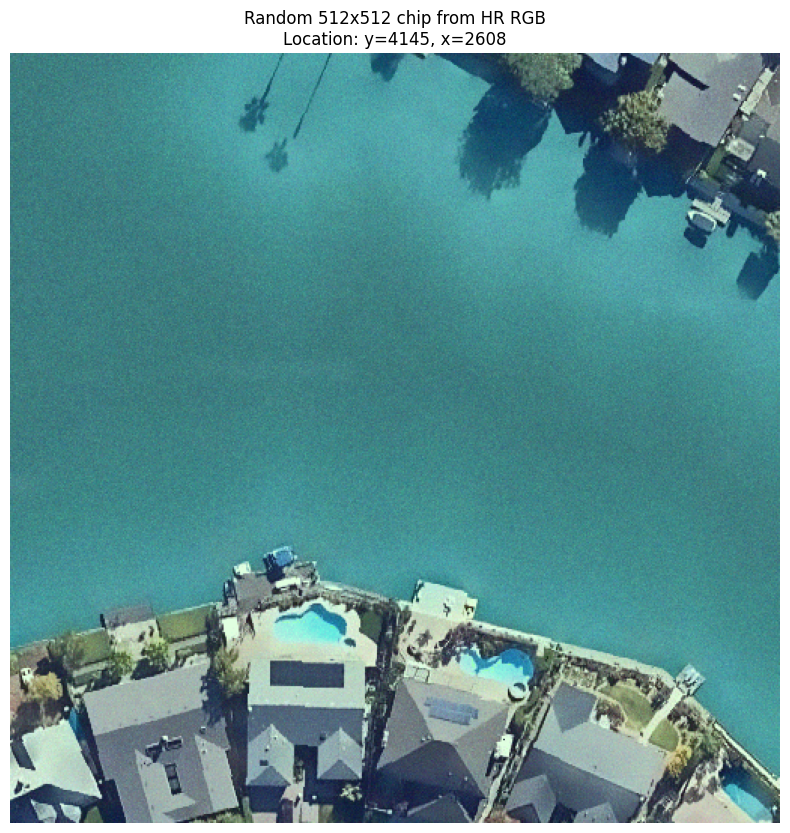

In [35]:
hr_data = display_hr_rgb(tree)

In [ ]:
# display full tree hr image
import matplotlib.pyplot as plt
import numpy as np

def display_hr_rgb_full(tree):
    """
    Display high-res RGB imagery from core-five datatree.
    
    Args:
        tree: xarray DataTree from core-five
    """
    # Access hr/data group - shape is (band, y, x)
    hr_data = tree["hr/data"].values
    n_bands, height, width = hr_data.shape
    print(f"Full image shape: {hr_data.shape} (band, y, x)")

    # FIX: Transpose from (band, y, x) to (y, x, band) for matplotlib
    hr_data = np.transpose(hr_data, (1, 2, 0))  # Now (height, width, band)
    print(f"Image shape after transpose: {hr_data.shape} (y, x, band)")

    # Normalize to 0-1 range if needed
    if hr_data.max() > 1.0:
        hr_data = hr_data / hr_data.max()
        print("Normalized image to 0-1 range")

    # Display
    plt.figure(figsize=(20, 20))
    plt.imshow(hr_data)
    plt.title("Full HR RGB Image")
    plt.axis('off')
    plt.show()

Full image shape: (3, 6278, 4453) (band, y, x)
Image shape after transpose: (6278, 4453, 3) (y, x, band)
Normalized image to 0-1 range


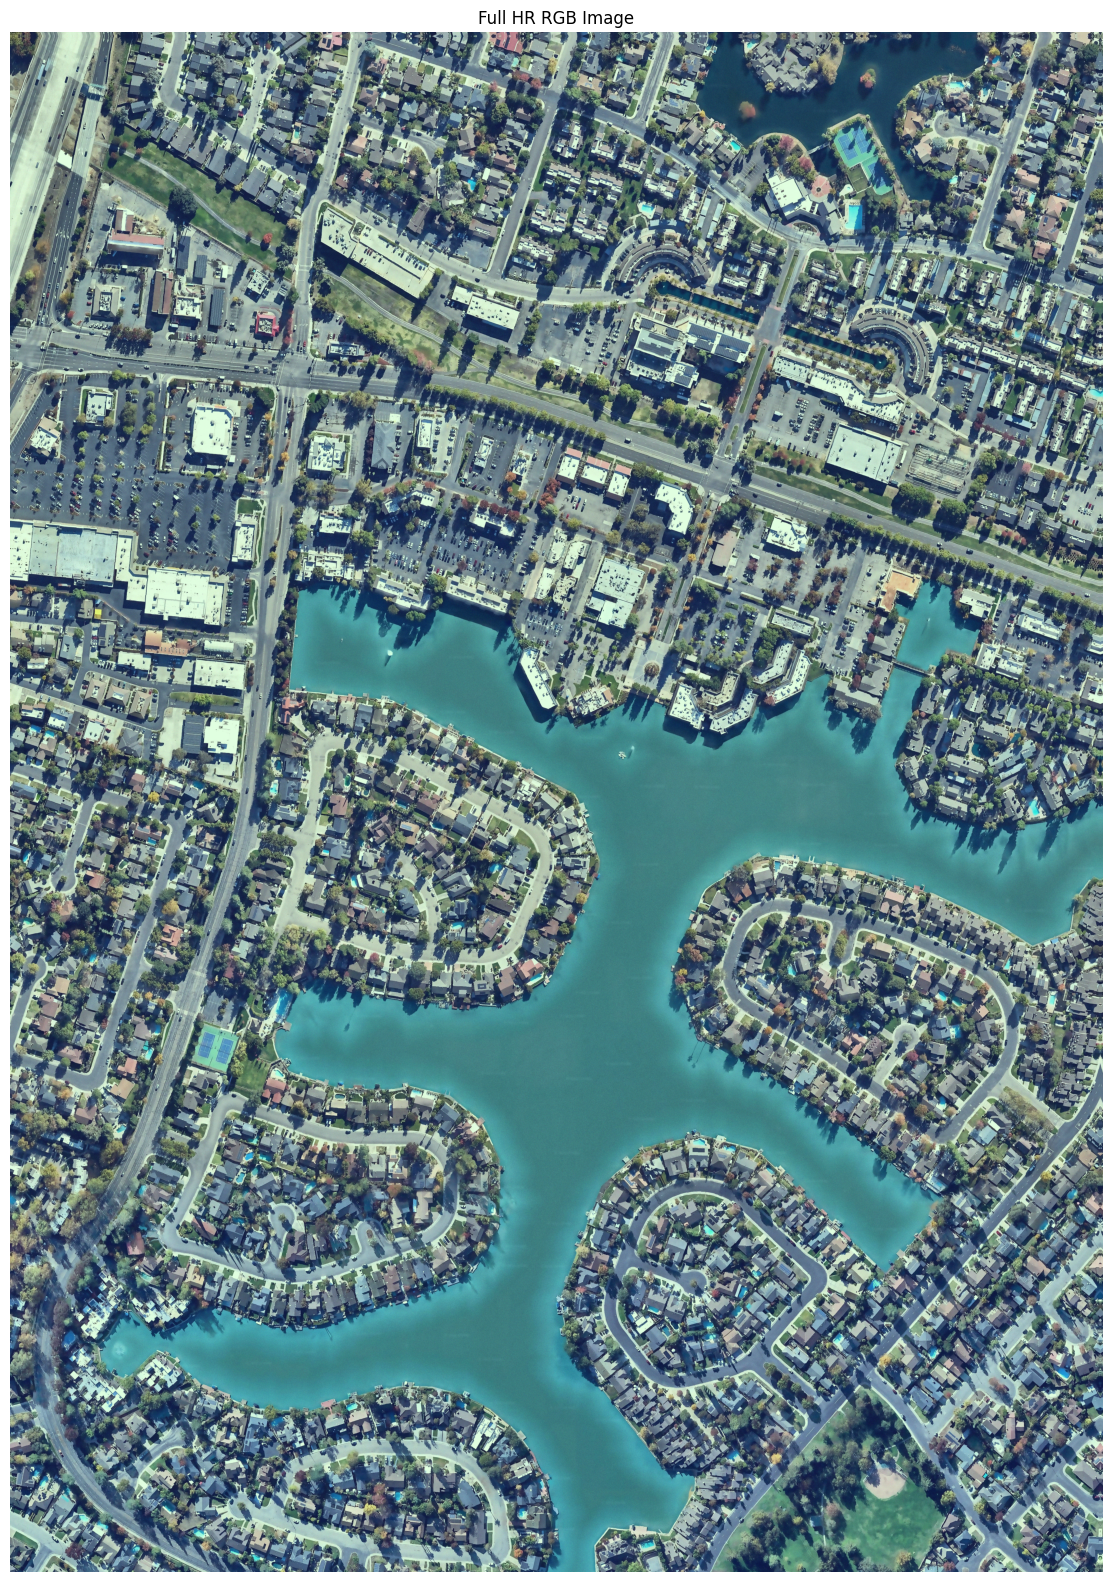

In [ ]:
display_hr_rgb_full(tree)

In [ ]:
# # Load a sample core-five file to inspect structure
# # Get first matched file from our results
# sample_matches = matches_df[matches_df['num_matches'] > 0]

# if len(sample_matches) > 0:
#     sample_file = sample_matches.iloc[0]['matched_files'][0]
    
#     # Construct full URL for the file
#     # HuggingFace path format: datasets/gajeshladhar/core-five/...
#     # Need to convert to resolve URL
#     full_url = f"https://huggingface.co/{core_five_root}/resolve/main"
    
#     print(f"Loading sample file: {sample_file}")
#     print(f"Full URL: {full_url}")
    
#     try:
#         # Try loading with xarray directly first
#         tree = xr.open_datatree(full_url)
        
#         print(f"\nDataTree structure:")
#         print(tree)
        
#         # Access specific modalities
#         if "hr/data" in tree:
#             hr_data = tree["hr/data"]
#             print(f"\nHigh-res RGB data shape: {hr_data.dims}")
        
#         if "s2" in tree:
#             s2_data = tree["s2"]
#             print(f"\nSentinel-2 data shape: {s2_data.dims}")
            
#     except Exception as e:
#         print(f"Error loading file: {e}")
#         print("\nNote: May need to adjust URL format or use VirtualiZarr for remote access")
# else:
#     print("No matched files found in sample. Try increasing the number of parent_dirs processed.")

Loading sample file: datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc
Full URL: https://huggingface.co/datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main
Error loading file: [Errno -77] NetCDF: Access failure: 'https://huggingface.co/datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main'

Note: May need to adjust URL format or use VirtualiZarr for remote access


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!doctype^ html><html class=""> <head>  <meta charset="utf-8" />  <meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=no" />  <meta name="description" content="We’re on a journey to advance and democratize artificial intelligence through open source and open science." />  <meta property="fb:app_id" content="1321688464574422" />  <meta name="twitter:card" content="summary_large_image" />  <meta name="twitter:site" content="@huggingface" />  <meta name="twitter:image" content="https://huggingface.co/front/thumbnails/v2-2.png" />  <meta property="og:title" content="404 – Hugging Face" />  <meta property="og:type" content="website" />  <meta property="og:url" content="https://huggingface.co/datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main.dds" />  <meta property="og:image" content="https://huggingface.co/front/thumbnails/v2-2.png" />  <l

In [ ]:
# Demonstrate VirtualiZarr approach for efficient data access
# This creates virtual references without loading actual data

if len(sample_matches) > 0:
    try:
        parser = HDFParser()
        
        # Open as virtual dataset
        vds = open_virtual_dataset(
            url=full_url,
            parser=parser,
            registry=registry,
            loadable_variables=['time']  # Only load small coordinate variables
        )
        
        print("Virtual dataset created successfully!")
        print(f"\nVirtual dataset info:")
        print(f"  Variables: {list(vds.data_vars)}")
        print(f"  Coordinates: {list(vds.coords)}")
        print(f"  Dimensions: {dict(vds.dims)}")
        print(f"\nMemory usage (virtual): {vds.vz.nbytes / 1024**2:.2f} MB")
        print(f"Actual data size: {vds.nbytes / 1024**2:.2f} MB")
        
    except Exception as e:
        print(f"VirtualiZarr error: {e}")
        print("\nThis is expected for the MVP - VirtualiZarr setup may need refinement for HuggingFace URLs")

VirtualiZarr error: The operation lacked valid authentication credentials for path datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main: Error performing HEAD https://huggingface.co/datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main in 283.534625ms - Server returned non-2xx status code: 401 Unauthorized: 

Debug source:
Unauthenticated {
    path: "datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main",
    source: RetryError(
        RetryErrorImpl {
            method: HEAD,
            uri: Some(
                https://huggingface.co/datasets/gajeshladhar/core-five/src/datatree/470af5/470af59c.nc/resolve/main,
            ),
            retries: 0,
            max_retries: 10,
            elapsed: 283.534625ms,
            retry_timeout: 180s,
            inner: Status {
                status: 401,
                body: Some(
                    "",
                ),
            },
        },
    ),
}

This 

### Next Steps for Full Implementation

1. **Scale S2 parsing**: Process all parent directories in core-five (not just first 100)
2. **Optimize matching**: Use spatial indexing for faster PV-to-core-five matching
3. **Implement buffering**: Add 100m buffer around PV labels for chip extraction
4. **Set up VirtualiZarr caching**: Configure local storage with virtualizarr for efficient subset retrieval
5. **Integrate SAM 2**: Add segmentation mask generation using box prompts
6. **Persist to Lance**: Store chips, masks, and metadata in Lance datasets

**Key Insights from MVP:**
- S2 cell levels in core-five dataset: [to be determined from actual run]
- Match rate: [to be determined from actual run]
- URL format for HuggingFace dataset access needs validation

In [ ]:
# Save intermediate results for next iteration
import pickle

# Save S2 cell mapping
with open('../data/s2_cell_mapping.pkl', 'wb') as f:
    pickle.dump(s2_cell_mapping, f)

# Save matched files
matches_df.to_parquet('../data/pv_core_five_matches.parquet')

# Save PV GeoDataFrame with S2 columns
pv_gdf.to_parquet('../data/pv_labels_with_s2.parquet')

print("Intermediate results saved to ../data/")

FileNotFoundError: [Errno 2] No such file or directory: '../data/s2_cell_mapping.pkl'